## import packages

In [1]:
import shutil
import cv2
import lxml
import glob
import time
import os

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# import ostwitter_data
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageEnhance
# import albumentations as albu

## **Create Dataframe from Images**

In [3]:
dirlist = ['../data/TBX11K/imgs/health', '../data/TBX11K/imgs/sick', '../data/TBX11K/imgs/tb']
classes = ['Healthy', 'Sick', 'Tuberculosis']
filepaths = []
labels = []
for d, c in zip(dirlist, classes):
    flist = os.listdir(d)
    for f in flist:
        fpath = os.path.join(d, f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  8400    labels:  8400


In [4]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=pd.DataFrame(np.array(df).reshape(8400,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

Healthy         3800
Sick            3800
Tuberculosis     800
Name: labels, dtype: int64


In [5]:
file_count = 800
samples = []
for category in df['labels'].unique():    
    category_slice = df.query("labels == @category")
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (df['labels'].value_counts())
print (len(df))

Sick            800
Healthy         800
Tuberculosis    800
Name: labels, dtype: int64
2400


In [6]:
df.head()

file_paths        labels
0    ../data/TBX11K/imgs/sick/s0942.png          Sick
1  ../data/TBX11K/imgs/health/h3600.png       Healthy
2    ../data/TBX11K/imgs/sick/s2649.png          Sick
3     ../data/TBX11K/imgs/tb/tb0125.png  Tuberculosis
4    ../data/TBX11K/imgs/sick/s0337.png          Sick

### **Visualize Images**

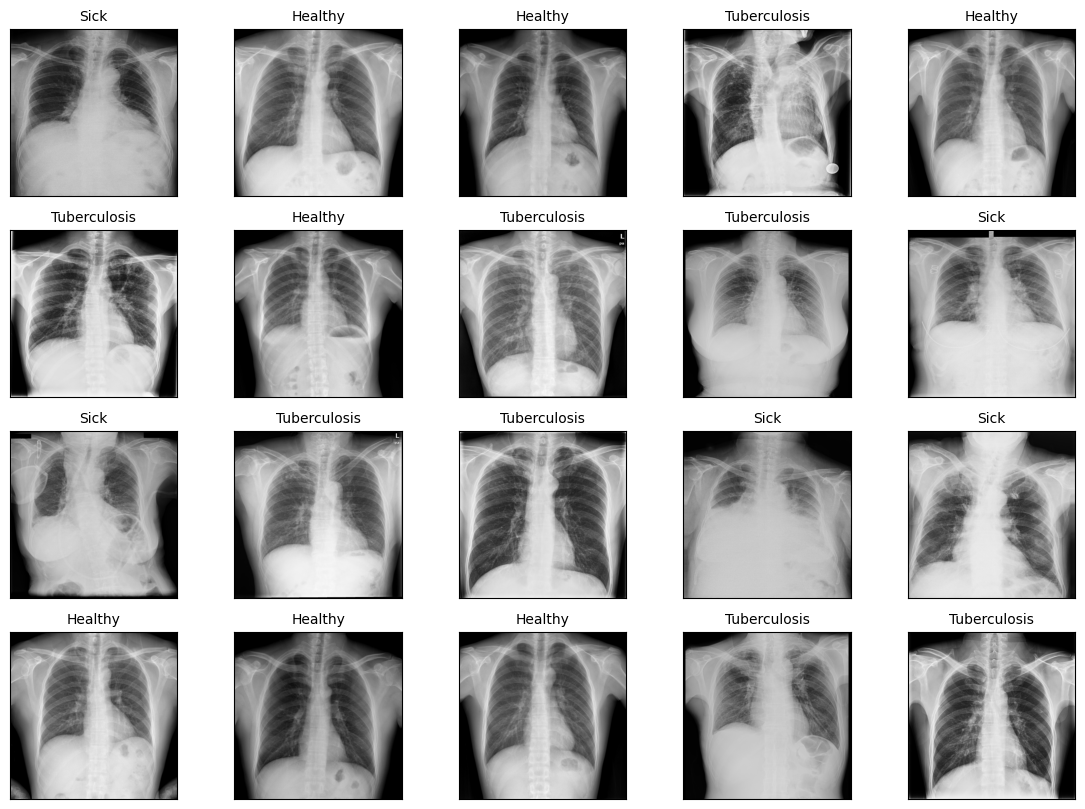

In [7]:
plt.figure(figsize=(14,10))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    img = df.loc[random,"file_paths"]
    plt.imshow(plt.imread(img))
    plt.title(df.loc[random, "labels"], size = 10, color = "black") 
    plt.xticks([])
    plt.yticks([])

    
plt.show()

### **Split Dataframe into Train, Valid, and Test**

In [8]:
train_df, test_df = train_test_split(df, train_size=0.95, random_state=0)
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)
print(train_df.labels.value_counts())
print(valid_df.labels.value_counts())
print(test_df.labels.value_counts())

Tuberculosis    685
Sick            684
Healthy         683
Name: labels, dtype: int64
Sick            79
Healthy         79
Tuberculosis    70
Name: labels, dtype: int64
Tuberculosis    45
Healthy         38
Sick            37
Name: labels, dtype: int64


### **ImageDataGenerator**

In [9]:
target_size=(224,224)
batch_size=16

In [10]:
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input, horizontal_flip=True)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)
    
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, 
    color_mode='rgb', class_mode='categorical')
valid_gen = test_datagen.flow_from_dataframe(
    valid_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, 
    color_mode='rgb', class_mode='categorical')
test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, 
    color_mode='rgb', class_mode='categorical')

Found 2052 validated image filenames belonging to 3 classes.
Found 228 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.


### DenseNet-121 model

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, Add
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import ReLU, concatenate, Layer
from tensorflow.keras.activations import sigmoid, softmax
import tensorflow.keras.backend as K


In [12]:
class ConvexCombination(Layer):
    def __init__(self, **kwargs):
        super(ConvexCombination, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd = self.add_weight(name='lambda',
                                     shape=(3, 1),  # Adding one dimension for broadcasting
                                     initializer=tf.keras.initializers.Constant(1/3),  # Try also 'ones' and 'uniform'
                                     trainable=True)
        super(ConvexCombination, self).build(input_shape)

    def call(self, x):
        h1, h2, h3 = x
        return self.lambd[0] * h1 + self.lambd[1] * h2 +  self.lambd[2] * h3

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [13]:
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters, block, kernel=1,strides=1):
        x = BatchNormalization(name="BN-"+block)(x)
        x = ReLU(name="relu-"+block)(x)
        x = Conv2D(filters, kernel, strides=strides, padding = 'same', name="conv-"+block)(x)
        return x
    
    def dense_block(x, repetition):
        for i in range(repetition):
            y = bn_rl_conv(x, 4*filters,str(repetition)+"-1-"+str(i))
            y = bn_rl_conv(y, filters, str(repetition)+"-2-"+str(i), kernel=3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x,block,pooling=True):
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2, block)
        if pooling:
            x = AvgPool2D(2, strides = 2, padding = 'same', name='avgp_'+str(block))(x)
        return x
     
    input = Input(input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    b_0 = dense_block(x, 6)
    b_0 = transition_layer(b_0,'tran-'+str(6))

    b_1 = dense_block(b_0, 12)
    b_1 = transition_layer(b_1,'tran-'+str(12))
    ex_1 = GlobalAveragePooling2D(name="GAP1")(b_1)
    ex_1 = Dense(n_classes, name='Dense1')(ex_1)

    b_2 = dense_block(b_1, 24)
    b_2= transition_layer(b_2,'tran-'+str(24))
    ex_2 = GlobalAveragePooling2D(name="GAP2")(b_2)
    ex_2 = Dense(n_classes, name='Dense2')(ex_2)

    b_3 = dense_block(b_2, 16)
    b_3 = transition_layer(b_3,'tran-'+str(16),pooling=False)
    ex_3 = GlobalAveragePooling2D(name="GAP3")(b_3)
    ex_3 = Dense(n_classes,name='Dense3')(ex_3)

    weighted_sum = ConvexCombination()([ex_1, ex_2, ex_3])
    classification_output = sigmoid(weighted_sum) 

    model = Model(input, classification_output)
    return model
input_shape = 512, 512, 3
n_classes = 3
model = densenet(input_shape,n_classes)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

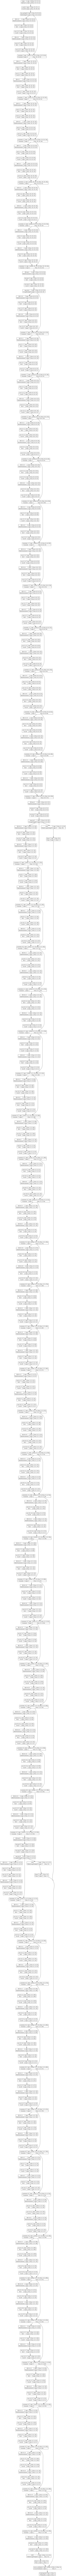

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [16]:
lr=0.0001
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(lr=lr), 
    metrics=['accuracy'])

/Users/user/projects/TB/bounding-box-lung-disease-detection/env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Custom callback

In [17]:
patience = 2
stop_patience = 5
factor = 0.2

callbacks = [ 
    tf.keras.callbacks.ModelCheckpoint(
        "classify_model.h5", monitor='val_loss', save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(
        patience=stop_patience, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

### Training

In [18]:
epochs = 30
history = model.fit(train_gen, 
    validation_data=valid_gen, 
    epochs=epochs, 
    callbacks=callbacks, 
    verbose=1)

Epoch 1/30


2023-02-23 09:02:09.191531: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


129/129 [==============================] - 301s 2s/step - loss: 0.4777 - accuracy: 0.8046 - val_loss: 2.1282 - val_accuracy: 0.3465 - lr: 1.0000e-04
Epoch 2/30
129/129 [==============================] - 308s 2s/step - loss: 0.2655 - accuracy: 0.8981 - val_loss: 2.6771 - val_accuracy: 0.3904 - lr: 1.0000e-04
Epoch 3/30
129/129 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9196
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
129/129 [==============================] - 306s 2s/step - loss: 0.2262 - accuracy: 0.9196 - val_loss: 5.8592 - val_accuracy: 0.3596 - lr: 1.0000e-04
Epoch 4/30
129/129 [==============================] - 298s 2s/step - loss: 0.1280 - accuracy: 0.9527 - val_loss: 0.3098 - val_accuracy: 0.8816 - lr: 2.0000e-05
Epoch 5/30
129/129 [==============================] - 299s 2s/step - loss: 0.1070 - accuracy: 0.9639 - val_loss: 0.2776 - val_accuracy: 0.9123 - lr: 2.0000e-05
Epoch 6/30
129/129 [=============================

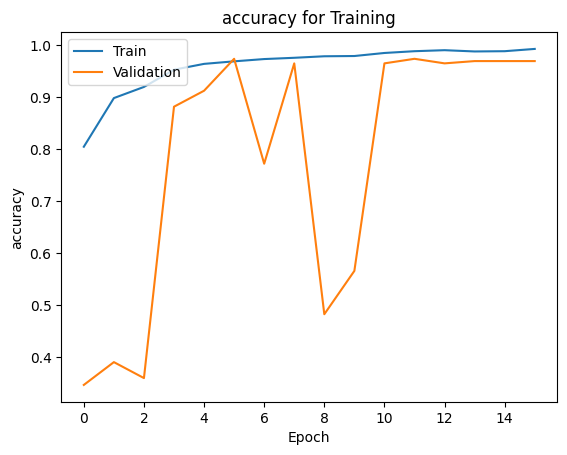

In [27]:
plt.plot(history.history['accuracy'], label='accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='accuracy (validation data)')
plt.title('accuracy for Training')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.show()

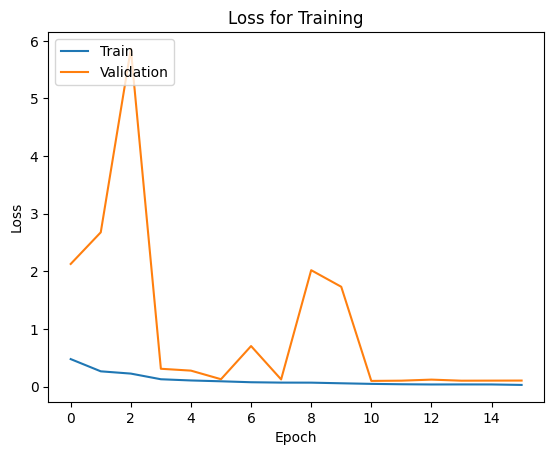

In [26]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc="upper left")
plt.show()

In [39]:
model.evaluate(test_gen)

8/8 [==============================] - 5s 540ms/step - loss: 0.0847 - accuracy: 0.9667


[0.08473357558250427, 0.9666666388511658]

In [38]:
model.load_weights('classify_model.h5')

In [40]:
def cam(img_array,conv_layer, output_layer):
    class_weights = model.get_layer(output_layer).get_weights()[0]

    print('shape of the weight is {}'.format(class_weights.shape))
    get_output = K.function(
                    [model.input], 
                    [model.get_layer(conv_layer).output, model.output])

    [conv_outputs, predictions] = get_output([img_array])
    cls = np.argmax(predictions)
    print(predictions)
    conv_outputs = conv_outputs[0, :, :, :]
    print("shape of the convolutional layer is {}".format(conv_outputs.shape))
    
    #Create the class activation map.
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, cls]):
            cam += w * conv_outputs[:, :, i]
    cam = tf.maximum(cam, 0) / tf.math.reduce_max(cam)
    return cam.numpy()

In [41]:
def resize_cam(heatmap, shape=(512,512)):
    heatmap = cv2.resize(heatmap, (512,512), interpolation = cv2.INTER_AREA)
    return heatmap

In [45]:
def generate_heatmap(cam):
    heatmap = np.uint8(255 * cam)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    #  # Create an image with RGB colorized heatmap
    # jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    # jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    return jet_heatmap


In [55]:
img = plt.imread('../data/TBX11K/imgs/sick/s0004.png')
# img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
img = np.expand_dims(img,0)

shape of the weight is (256, 3)
[[3.3115924e-04 3.5817997e-05 8.8253623e-01]]
shape of the convolutional layer is (32, 32, 256)
shape of the weight is (512, 3)
[[3.3115924e-04 3.5817997e-05 8.8253623e-01]]
shape of the convolutional layer is (16, 16, 512)
shape of the weight is (512, 3)
[[3.3115924e-04 3.5817997e-05 8.8253623e-01]]
shape of the convolutional layer is (16, 16, 512)
(512, 512, 3)


/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/ipykernel_53569/2927806052.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


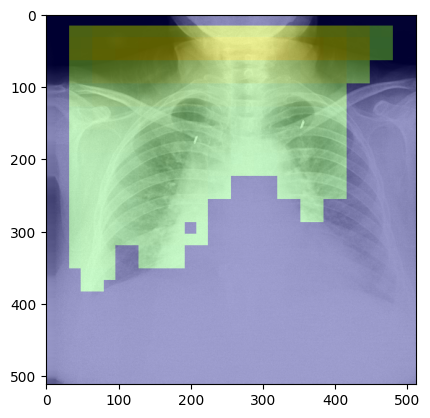

In [58]:
layers = [('avgp_tran-12','Dense1'),('avgp_tran-24','Dense2'),('conv-tran-16','Dense3')]
heatmaps=[]
for layer in layers:
    heatmap = cam(img,layer[0],layer[1])
    resized_heatmap = resize_cam(heatmap)
    heatmaps.append(resized_heatmap)
    
block_weights = model.get_layer('convex_combination').get_weights()[0]
weighted_sum_heatmap = np.zeros((512,512))
for i,weight in enumerate(block_weights):
    weighted_sum_heatmap += weight * heatmaps[i]
weighted_sum_heatmap = np.where(weighted_sum_heatmap>0.5,weighted_sum_heatmap,0) 
final_heatmap = generate_heatmap(weighted_sum_heatmap)
alpha=0.5
img_array = np.squeeze(img)
print(img_array.shape)

superimposed_img = final_heatmap * alpha + img_array
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
plt.imshow(superimposed_img)